# First Baruch Volatility Workshop
<p>

## Session 2: Computationally tractable stochastic volatility models

<p>

Instructor: Jim Gatheral   
  
  
<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/07/BaruchLogo2.png" align = "left" width=160></h3>      <h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/07/MFElogo.png" align = "right" width=100></h3>

## Outline of Session 2

- Models with closed-form characteristic functions


- Visualizing the effect of changing model parameters

    - Correlation
    - Volatility of volatility
    - Mean reversion
    - Jumps in the underlying
    - Simultaneous jumps in the underlying and volatility 


- How jumps affect the volatility surface


###Computationally tractable stochastic volatility models

- Stochastic volatility models tend to be hard to compute with.
    - Although this isn't always true, it is true for models with realistic dynamics.


- Models with closed-form characteristic functions are attractive because they have easy-to-compute solutions for European options.


- Such models tend to fall into two main (possibly ovelapping) classes:

    - Lévy processes (possibly time-changed).
    - Affine processes

### Lévy Processes



<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
Lévy Process</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>

A Lévy process is a continuous in probability, càdlàg stochastic
process $x(t),\, t>0$ with independent and stationary increments and
$x(0) = 0$.
<br>
<br>


</div>

</blockquote>


* It turns out that any Lévy process can be expressed as the sum of a linear drift term, a Brownian motion and a jump process.

* This plus the independent increment property leads directly to the Lévy-Khintchine representation for the characteristic function.

### The Lévy-Khintchine representation

If $x_t$ is a Lévy process, and if the Lévy density $\mu(\xi)$ is suitably well-behaved at the origin, its characteristic function $\phi_T(u):=\mathbb{E}\left[e^{i u x_T}\right]$ has the representation


<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
Characteristic function for a Lévy process</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>

<a name="eq:lk"></a>(1)
$$
\phi_T(u)=\exp\left\{i \,u\, \omega\, T -\frac{1}{2}u^2\, \sigma^2 T +T
\int \left[e^{i \,u \,\xi}-1\right]\mu(\xi)\,d\xi\right\}
$$

<br>
<br>


</div>

</blockquote>

To get the drift parameter $\omega$, we impose that the risk-neutral expectation of the stock price be the forward price. With our current assumption of zero interest rates and dividends, this translates to
imposing that 

$$\phi_T(-i)=\mathbb{E}\left[e^{x_T}\right]=1$$ 


Here, $\int \mu(\xi)\,d\xi = \lambda$, the Poisson intensity or mean jump arrival rate also known as the *hazard* rate.

### Example: Black-Scholes

The characteristic function for an exponential Brownian motion with volatility $\sigma$ is given by

$$
\phi_T(u)=\mathbb{E}\left[e^{iu x_T}\right]=
\exp\left\{-{\frac{1}{2}}{u\,(u+i)\,\sigma^2T}\right\}
$$

We can get this result by performing the integration explicitly or directly from the Lévy-Khintchine representation.

### Example: Merton’s Jump-Diffusion Model

In the Merton jump-diffusion (MJD) model, jumps $J$ are assumed to be lognormally distributed with mean log-jump size $\alpha$ and standard deviation $\delta$ so that the stock
price follows the SDE

$$
dS = \mu  S\, dt + \sigma S\, dZ +(e^{\alpha+\delta
\epsilon}-1)S\,dq
$$

with $\epsilon \sim N(0,1)$. Then

$$\mu(\xi)=\frac{\lambda}{\sqrt{2 \pi \delta^2}}\exp
\left\{-\frac{(\xi-\alpha)^2}{2 \delta^2 }\right\}$$

Applying the Lévy-Khintchine representation [(1)](#eq:lk), we obtain

<a name="eq:jumpdiffusioncharfn"></a>(2)
$$
\begin{eqnarray*}
\phi_T(u) &=& \exp \bigg\lbrace i u \omega T -\frac{1}{2}u^2\, \sigma^2 T + T \int \left[e^{i u \xi}-1\right] \frac{\lambda}{\sqrt{2 \pi \delta^2}} \exp \bigg\lbrace -\frac{(\xi-\alpha)^2}{2 \delta^2} \bigg\rbrace
\,d\xi \bigg\rbrace 
\\
&=&\exp \bigg\lbrace i u \omega T -\frac{1}{2}u^2\, \sigma^2 T +\lambda T
\left( e^{i u \alpha -u^2 \delta^2/2}-1 \right) \bigg\rbrace.
\end{eqnarray*}
$$

To get $\omega$, we impose $\phi_T(-i)=1$ so that

$$\exp\left\{ \omega T +\frac{1}{2}\, \sigma^2 T +\lambda T \left(
e^{ \alpha + \delta^2/2}-1 \right) \right\}=1$$ 

which gives

$$\omega=-\frac{1}{2}\,\sigma^2 -\lambda \left( e^{ \alpha +
\delta^2/2}-1 \right)$$ 

Unsurprisingly, we get the lognormal case back
when we set $\alpha=\delta=0$.

### Set up R environment

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

download.file(url="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/04/VW2.zip", destfile="VW2.zip")
unzip(zipfile="VW2.zip")

trying URL 'http://mfe.baruch.cuny.edu/wp-content/uploads/2015/04/VW2.zip'
Content type 'application/zip' length 3867 bytes
opened URL
downloaded 3867 bytes



In [3]:
%%R

source("BlackScholes.R")
source("svi.R")
source("plotIvols.R")
source("Heston2.R")
source("sviVolSurface.R") 


###R-code for the Merton jump-diffusion characteristic function

In [4]:
%%R

phiMJD <- function(params){
    
    sigma <- params$sigma
    lambdaJ <- params$lambdaJ
    alpha <- params$alpha
    delta <- params$delta
    
    function(u, t){

    psiBS <- -u/2*(u+1i)*sigma^2
    psiJump <- lambdaJ*(-1i*u*(exp(alpha+delta^2/2)-1) + (exp(1i*u*alpha-u^2*delta^2/2)-1))
        
    return(exp((psiBS+psiJump)*t))
}
}

In [5]:
%%R

paramsMJD1 <- list(sigma=0.2, lambdaJ = 0.5, alpha = -0.15, delta = .05)

phiMJD(paramsMJD1)(.1,1)

[1] 0.9997342-0.0025882i


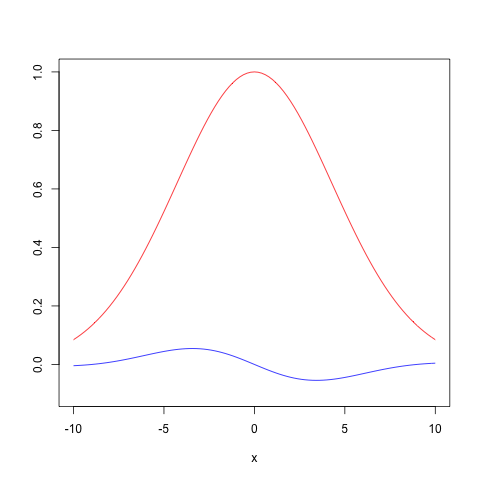

In [6]:
%%R

curve(Re(phiMJD(paramsMJD1)(x,1)),from=-10,to=10,col="red",ylim=c(-.1,1),ylab=NA)
curve(Im(phiMJD(paramsMJD1)(x,1)),from=-10,to=10,col="blue",add=T)

Figure 1: Real (red) and imaginary (blue) parts of the MJD characteristic function.

###Some notable features of R



* Complex arithmetic with $\text{1i}$.

* Lexical scoping
    * This is what allows us to code a function which is called as: 
    
            phiMJD(params)(u,t)
    
    * We can define a function that returns a function (and so on indefinitely).
    
    * We could even conveniently define a new function: 
          
            phiMJD1 <- phiMJD(paramsMJD1)

    * We can conceptually separate parameters and variables rather than having to carry all the parameters around with each function call.

### Affine processes

The following explanation is due to Martin Keller-Ressel:

**Definition** 
 
An *affine process* can be described as a Markov process whose log-characteristic function is an affine 
function of its initial state vector.


And here's a definition of the word *affine* from Wikipedia:

**Definition** 

In geometry, an affine transformation or affine map or an affinity (from the Latin, affinis, "connected with") between two vector spaces (strictly speaking, two affine spaces) consists of a linear transformation followed by a translation:
$$
x \mapsto A\,x+b
$$

###The Heston process

The Heston SDE is

$$
\begin{eqnarray*}
dS &=& \sqrt {v} \,S\, dZ_1 \nonumber\\
dv &=&  - \lambda (v - \bar v)\,dt + \eta \,\sqrt {v}\,
dZ_2
\end{eqnarray*}
$$

with

$$
\left\langle {dZ_1 \,{dZ_2} } \right\rangle = \rho \,{ dt}.
$$

- Heston returns are far from independent (for example squared returns are highly autocorrrelated) so it is not a Lévy process. 


- However, because the Heston process is affine, as shown by [Duffie, Pan and Singleton]<sup id="cite_ref-DPS" class="reference"><a href="#cite_note-DPS"><span>[</span>3<span>]</span></a></sup>) , it has a closed-form characteristic function (as derived in for example Chapter 3 of [The Volatility Surface]<sup id="cite_ref-TVS" class="reference"><a href="#cite_note-TVS"><span>[</span>4<span>]</span></a></sup>) ).


- The Heston characteristic function is:

$$
\phi_{HEST}(u)=e^{ C (u,t )\,\bar v + D (u,t)\,v}
$$

with $C(u,t)$ and $D(u,t)$ complicated functions of the parameters.

###$C(u,t)$ and $D(u,t)$

In terms of the Heston parameters $\eta$, $\lambda$ and $\rho$, first define:

$$
  \alpha =  - \frac{{u^2 }}{2} - \frac{{i \,u}}{2};\,
  {\beta} = \lambda  - \rho\, \eta\, i\, u ;\,
  \gamma = \frac{{\eta ^2 }}{2} ;
$$

Then define

$$
r_ \pm   = \frac{{\beta  \pm \, \sqrt {\beta ^2  - 4\alpha \gamma }
}}{{2\gamma }} =: \frac{{\beta  \pm d}}{{\eta ^2 }}
$$

and

$$
g := \frac{{r_ -  }}{{r_ +  }}
$$

Finally we have:

$$
\begin{eqnarray}
D(u,\tau ) &=& r_ -  \frac{{1 - e^{ - d\,\tau } }}{{1 - g\,e^{ -
d\,\tau } }} \nonumber\\ C(u,\tau ) &=& \lambda \,\left\{ {r_ - \tau
- \frac{2}{{\eta ^2 }}\,\log\left( {\frac{{1 - g\,e^{ - d\,\tau }
}}{{1 - g}}} \right)} \right\}
\end{eqnarray}
$$

###The Heston characteristic function: R-code

In [7]:
%%R

phiHeston <- function(params){

    lambda <- params$lambda; rho <- params$rho; eta <- params$eta;
    vbar <- params$vbar; v <- params$v;

    function(u, t){
    al <- -u*u/2 - 1i*u/2;
    bet <- lambda - rho*eta*1i*u;
    gam <- eta^2/2;
    d <- sqrt(bet*bet - 4*al*gam);
    rp <- (bet + d)/(2*gam);
    rm <- (bet - d)/(2*gam);
    g <- rm / rp;
    D <- rm * (1 - exp(-d*t))/ (1 - g*exp(-d*t));
    C <- lambda * (rm * t - 2/eta^2 * log( (1 - g*exp(-(d*t)))/(1 - g) ) );
    return(exp(C*vbar + D*v));
}
}


####Bakshi, Cao and Chen (BCC) parameters:

[Bakshi, Cao and Chen]<sup id="cite_ref-BCC" class="reference"><a href="#cite_note-BCC"><span>[</span>1<span>]</span></a></sup> found the following parameters (more or less) from their fit of the Heston model:

In [8]:
%%R

paramsBCC <- list(lambda = 1.15,rho = -0.64,eta = 0.39,vbar = 0.04,v = .04)

phiHeston(paramsBCC)(.1,1)

[1] 0.9997793-0.0019974i


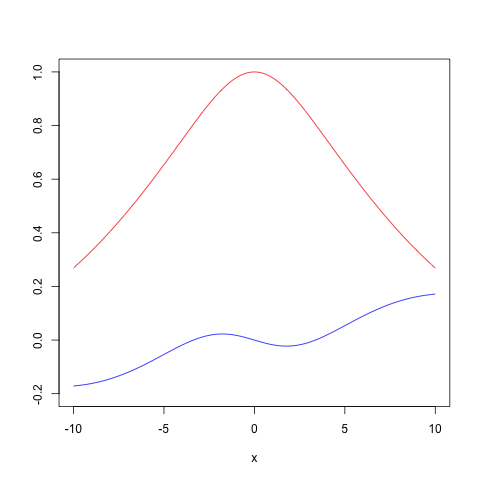

In [9]:
%%R

curve(Re(phiHeston(paramsBCC)(x,1)),from=-10,to=10,col="red",ylim=c(-.2,1),ylab=NA)
curve(Im(phiHeston(paramsBCC)(x,1)),from=-10,to=10,col="blue",add=T)

Figure 2: Real (red) and imaginary (blue) parts of the Heston characteristic function.

###Computing European option prices from the characteristic function


It turns out (see [Carr and Madan]<sup id="cite_ref-CarrMadan" class="reference"><a href="#cite_note-CarrMadan"><span>[</span>2<span>]</span></a></sup> and [Lewis]<sup id="cite_ref-Lewis" class="reference"><a href="#cite_note-Lewis"><span>[</span>5<span>]</span></a></sup>) that it is quite
straightforward to get option prices by inverting the characteristic
function of a given stochastic process (if it is known in closed-form).


The formula we will use is a special case of formula (2.10) of Lewis (as
usual we assume zero interest rates and dividends):

<blockquote><div style="background-color:#E8E8E8; color:#000000; font-style: normal;">

<a name="eq:lewis"></a>(3)
\begin{equation}
C(S,K,T)=S-\sqrt{SK}\frac{1}{\pi}\int_0^\infty\frac{du}{u^2+\frac{1}{4}}
\,\mathrm{Re}\left[e^{-iuk}\phi_T\left(u-i/2\right)\right]
\end{equation}

with $k=\log\left(\frac{K}{S}\right)$. 

</div></blockquote>

- The proof of this formula is provided in *The Volatility Surface*.

#### R implementation

In [10]:
%%R

callOption <- function(phi, k, t){
    integrand <-  function(u){Re(exp(-1i*u*k)*phi(u - 1i/2, t)/(u^2 + 1/4))}
    res <- 1 - exp(k/2)/pi*integrate(integrand,lower=0,upper=Inf)$value
    return(res)
}

In [11]:
%%R

print(callOption(phiMJD(paramsMJD1), 0, 1))
bsvol(phiMJD(paramsMJD1),0,1)

[1] 0.0898486
[1] 0.2256951


###Implied volatility from the characteristic function


Equation [(3)](#eq:lewis) allows us to derive an elegant implicit expression
for the Black-Scholes implied volatility of an option in any model for
which the characteristic function is known.

Substituting the characteristic function for the Black-Scholes process
into [(3)](#eq:lewis) gives

$$
C_{BS}(S,K,T)=S-\sqrt{SK}\frac{1}{\pi}\int_0^\infty\frac{du}{u^2+\frac{1}{4}}
\,\mathrm{Re}\left[e^{-iuk}e^{-\frac{1}{2}\left(u^2+\frac{1}{4}\right)\sigma_{BS}^2
T }\right]
$$

Then, from the definition of implied volatility, we must have

<a name="eq:ImpliedFromFourier"></a>(4)
$$
\newcommand{\BS}{\text{BS}}
 \int_0^\infty \frac{du}{u^2+\frac{1}{4}} \,\mathrm{Re} \bigg[ e^{-iuk} \bigg(\phi_T(u-i/2) - e^{ -\frac12 \, \left( u^2+\frac{1}{4} \right) {\sigma_{\BS}^2} T }\bigg) \bigg] = 0
$$



* Equation [(4)](#eq:ImpliedFromFourier) gives us a simple but implicit relationship between the implied volatility surface and the characteristic function of the underlying stock process.

    * We may efficiently compute the structure of at-the-money implied volatility and the at-the-money volatility skew in terms of the characteristic function (at least numerically) without having to explicitly compute option prices.


* In practice, computing the option price and numerically inverting the Black-Scholes formula to get the implied volatility is faster.

### Computing the at-the-money volatility skew

Assume $\phi_T$ does not depend on spot $S$ and hence not on $k$. (This
is the case in all examples we have in mind.) Then differentiating
[(5)](#eq:ImpliedFromFourier) with respect to k and evaluating at $k=0$
gives 

$$
\int_0^\infty\,du \, \left\{ \frac{u\,
\mathrm{Im}\left[\phi_T(u-i/2) \right]}{u^2+\frac{1}{4}}
+\frac{1}{2}\,\left.\frac{\partial w_{BS} }{\partial k
}\right|_{k=0}\,e^{-\frac{1}{2}\left(u^2+\frac{1}{4}\right)w_{BS}(0,
T)}\right\}=0
$$

Integrating the second term explicitly we get

<a name="eq:skew"></a>(6)

$$
\left.\frac{\partial \sigma_{BS} }{\partial k }\right|_{k=0} = -
e^{\frac{\sigma_{BS}^2 T}{8}} \sqrt{\frac{2}{ \pi}} \frac{1}{
\sqrt{T}}\,\int_0^\infty\,du \, \frac{u\,
\mathrm{Im}\left[\phi_T(u-i/2)\right] }
{u^2+\frac{1}{4}}.
$$



<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
Example: Black-Scholes
</h4>

</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>


In the Black-Scholes case, 

$$\mathrm{Im}\left[\phi_T(u-i/2)\right]
=\mathrm{Im}\left[e^{-\frac{1}{2}\left(u^2+1/4\right)\sigma^2 T
}\right]=0$$ 

Then 

$$\left.\frac{\partial \sigma_{BS}(k,T) }{\partial k
}\right|_{k=0}=0 \ \ \forall T>0.$$

<br>

</div>

</blockquote>






<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;" ><h4>

Example: Merton’s Jump-Diffusion Model (JD)
</h4>


</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>


Write 

$$\phi_T(u) =e^{-\frac{1}{2}u(u+i)\sigma^2 T}\,e^{\psi(u) T}$$

<br>
with $\psi(u)=-\lambda i u \left(e^{\alpha
+\delta^2/2}-1\right)+\lambda\left( e^{i u \alpha -u^2
\delta^2/2}-1 \right)$

<br>

Then 


$$\mathrm{Im}\left[\phi_T(u-i/2)\right]
=e^{-\frac{1}{2}\left(u^2+\frac{1}{4}\right)\sigma^2
T}\,\mathrm{Im}\left[e^{\psi(u-i/2) T} \right]$$



<br>

</div>

</blockquote>

###Computing ATM skew from the characteristic function: R-code

The following R-code implements formula [(6)](#eq:skew):

In [12]:
%%R

atmSkew <- function(phi, t){
  atmVol <- BSImpliedVolCall(S0=1, K=1, T=t, r=0, C=callOption(phi, 0, t)) 
  integrand <-  function(u){Im(u*phi(u - 1i/2, t)/(u^2 + 1/4))} 
  res <- -integrate(integrand,lower=0,upper=Inf,rel.tol=0.0000000001,subdivisions=1000)$value/sqrt(t)*sqrt(2/pi)*exp(atmVol^2*t/8) 
  return(res) 
}

# Vectorize the function
atmSkewV <- function(phi,tVec){sapply(tVec,function(t){atmSkew(phi,t)})} 

###Term structure of Heston skew

With the same Heston parameters, we obtain the following plot of the Heston ATM volatility skew.

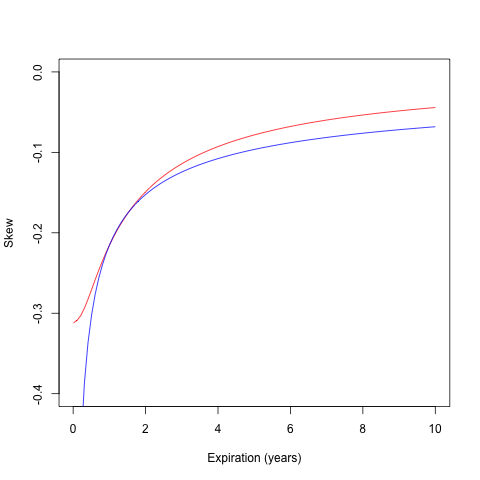

In [13]:
%%R

(skew1 <- atmSkew(phiHeston(paramsBCC),1))

curve(atmSkewV(phiHeston(paramsBCC),x),from=.01,to=10,col="red",ylim=c(-.4,0),ylab="Skew",xlab="Expiration (years)")
par(new=T)
curve(skew1/sqrt(x),from=.01,to=10,col="blue",add=T)

Figure 3: ATM Heston volatility skew (in red) with $1/\sqrt{\tau}$ superimposed (in blue).

### The Heston smile

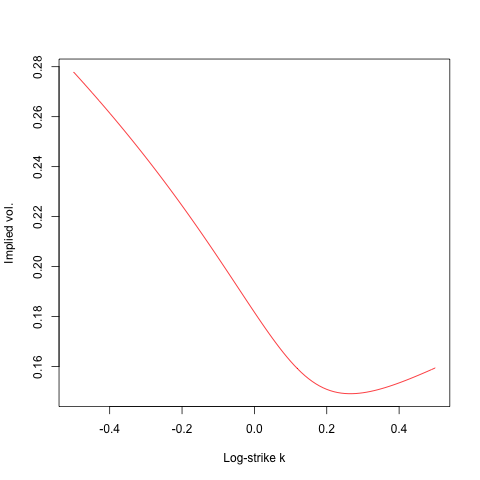

In [14]:
%%R

vol <- function(k){sapply(k,function(x){impvolHeston(paramsBCC)(x,1)})}
curve(vol(x),from=-.5,to=.5,col="red",ylab="Implied vol.",xlab="Log-strike k")

Figure 4: Heston 1 year smile with BCC parameters.

###Sensitivity of the Heston smile to $\rho$

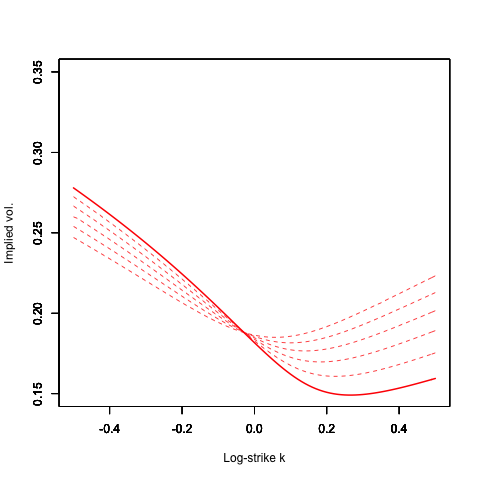

In [15]:
%%R
#First rho
subH <- function(incr){
    tmp <- paramsBCC
    tmp$rho <- tmp$rho+incr
    return(tmp)
}

yrange <- c(0.15,.35)
vol <- function(k){sapply(k,function(x){impvolHeston(paramsBCC)(x,1)})}
curve(vol(x),from=-.5,to=.5,col="red",ylim=yrange,lwd=2,ylab="Implied vol.",xlab="Log-strike k")
for (incr in seq(0.1,0.5,0.1))
    {
        for (i in 1:100000){tmp=i}
        par(new=T)
        vol <- function(k){sapply(k,function(x){impvolHeston(subH(incr))(x,1)})
    }
    curve(vol(x),from=-.5,to=.5,col="red",lty=2,ylim=yrange,ylab=NA,xlab=NA)
}

Figure 5: The dotted lines are smiles with $\rho=\rho_{BCC}+\{0.1,0.2,0.3,0.4,0.5\}$.

###Sensitivity of the Heston smile to $\eta$

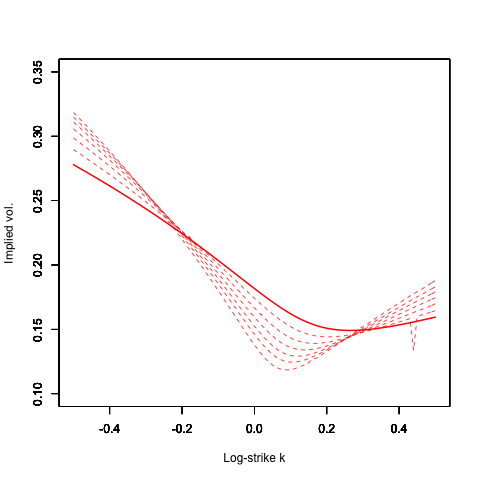

In [16]:
%%R
# Next eta:
subH <- function(incr){
    tmp <- paramsBCC
    tmp$eta <- tmp$eta+incr
    return(tmp)
}

yrange <- c(0.1,.35)
vol <- function(k){sapply(k,function(x){impvolHeston(paramsBCC)(x,1)})}
curve(vol(x),from=-.5,to=.5,col="red",ylim=yrange,lwd=2,ylab="Implied vol.",xlab="Log-strike k")
for (incr in c(seq(0.1,0.5,0.1),0.64))
    {
    for (i in 1:100000){tmp=i}
    par(new=T)
    vol <- function(k){sapply(k,function(x){impvolHeston(subH(incr))(x,1)})
    }
    curve(vol(x),from=-.5,to=.5,col="red",lty=2,ylim=yrange,ylab=NA,xlab=NA)
}

Figure 6: The dotted lines are smiles with $\eta=\eta_{BCC}+\{0.1,0.2,0.3,0.4,0.5\}$. 

###Sensitivity of the Heston smile to $\lambda$

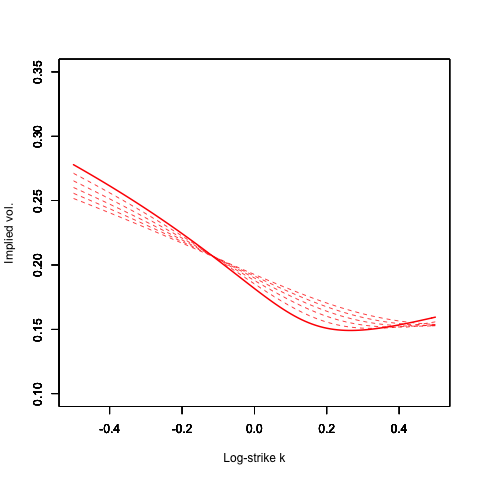

In [17]:
%%R
# Finally lambda:
subH <- function(incr){
    tmp <- paramsBCC
    tmp$lambda <- tmp$lambda+incr
    return(tmp)
}

yrange <- c(0.1,.35)
vol <- function(k){sapply(k,function(x){impvolHeston(paramsBCC)(x,1)})}
curve(vol(x),from=-.5,to=.5,col="red",ylim=yrange,lwd=2,ylab="Implied vol.",xlab="Log-strike k")
for (incr in seq(0.5,2.5,0.5))
    {
        for (i in 1:100000){tmp=i}
        par(new=T)
        vol <- function(k){sapply(k,function(x){impvolHeston(subH(incr))(x,1)})
    }
curve(vol(x),from=-.5,to=.5,col="red",lty=2,ylim=yrange,ylab=NA,xlab=NA)
}

Figure 7: The dotted lines are smiles with $\lambda=\lambda_{BCC}+\{0.5,1.0,1.5,2.0,2.5\}$.

###Another sensitivity plot

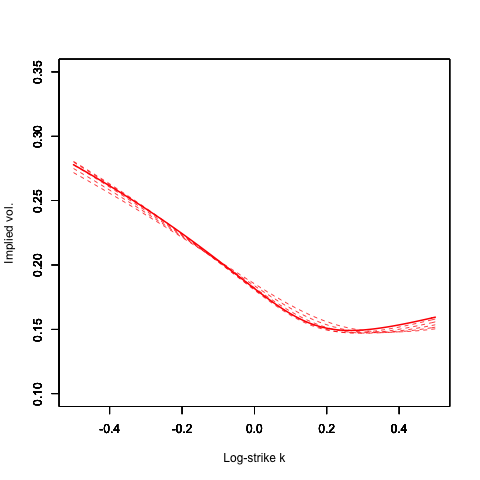

In [18]:
%%R
# Also, increase both lambda and eta keeping eta^2/lambda constant.
subH <- function(incr){
    tmp <- paramsBCC
    tmp$eta <- tmp$eta+incr
    tmp$lambda <- tmp$lambda*(tmp$eta/paramsBCC$eta)^2
    return(tmp)
}

yrange <- c(0.1,.35)
vol <- function(k){sapply(k,function(x){impvolHeston(paramsBCC)(x,1)})}
curve(vol(x),from=-.5,to=.5,col="red",ylim=yrange,lwd=2,ylab="Implied vol.",xlab="Log-strike k")
for (incr in seq(0.1,0.5,0.1))
    {
    for (i in 1:100000){tmp=i}
    par(new=T)
    vol <- function(k){sapply(k,function(x){impvolHeston(subH(incr))(x,1)})
    }
curve(vol(x),from=-.5,to=.5,col="red",lty=2,ylim=yrange,ylab=NA,xlab=NA)
}


Figure 8: The dotted lines are smiles with $\eta=\eta_{BCC}+\{0.1,0.2,0.3,0.4,0.5\}$ and $\lambda$ incremented so as to keep the ratio $\lambda/\eta^2$ constant. 

###Stochastic volatility plus jumps in the underlying only (SVJ)

Suppose we add a simple Merton-style lognormally distributed jump
process to the Heston process so that

\begin{eqnarray*}
dS &=& \mu \, S\, dt +  \sqrt{v}\,S\, dZ_1 +\left(e^{\alpha+\delta\,\epsilon}-1\right)\,S\,dq\\
dv &=&  - \lambda (v - \bar v)\,dt + \eta \,\sqrt {v}\, dZ_2
\end{eqnarray*}

with $ \left\langle {dZ_1 \,{dZ_2} } \right\rangle = \rho \,{ dt}$,
$\epsilon \sim N(0,1)$ and as in the jump-diffusion case, the
Poisson process

$$
dq=
\left\{ {\begin{array}{*{10}l}
   &0&\textrm{ with probability }1- \lambda_J\, dt  \\
   &1&\textrm{ with probability } \lambda_J \, dt \\
\end{array}}
\right.
$$

where $\lambda_J$ is the jump intensity (or hazard rate)

### SVJ characteristic function

By substitution into the valuation equation, it is easy to see that the
characteristic function for the SVJ process is just the product of
Heston and jump characteristic functions. Specifically,

$$\phi_T(u) =e^{C(u,T)\,\bar v+D(u,T)\,v} \,e^{\psi(u) T}$$

with
$\psi(u)=-\lambda_J i u \left(e^{\alpha +\delta^2/2
}-1\right)+\lambda_J\left( e^{i u \alpha-u^2 \delta^2/2 }-1
\right)$ and $C(u,T)$, $D(u,T)$ are as before.

We may substitute this functional form into equations [(4)](#eq:ImpliedFromFourier) and [(6)](#eq:skew) to get the
implied volatilities and at-the-money volatility skew respectively for
any given expiration.

### SVJ ATM variance skew

In [19]:
%%R

atmVarSkew <- function(phi, t){
    volSkew <- atmSkew(phi,t) 
    atmVol <- bsvol(phi,0,t) 
    return(2*volSkew*atmVol) 
}

# Vectorize the function
atmVarSkewV <- function(phi,tVec){sapply(tVec,function(t){atmVarSkew(phi,t)})} 

### Some empirical fits to the SPX volatility surface


| Author(s) | Model |   $\mathbf{\lambda}$   |   $\mathbf{\eta}$   |  $\mathbf{\rho}$     |   $\bar v$    |   $\mathbf{\lambda_J}$    |    $\mathbf{\alpha}$     |     $\mathbf{\delta}$   |
|-----------|------|-----:|-----:|------:|------:|------:|--------:|-------:|
| AA        |    MJD |   NA |   NA |    NA | 0.032 | 0.089 | -0.8898 | 0.4505 |
| BCC       |   SVJ | 2.03 | 0.38 | -0.57 |  0.04 |  0.59 |   -0.05 |   0.07 |
| M         |   SVJ |  1.0 |  0.8 |  -0.7 |  0.04 |   0.5 |   -0.15 |      0 |
| DPS       |   SVJ | 3.99 | 0.27 | -0.79 | 0.014 |  0.11 |   -0.12 |   0.15 |
| JG        |   SVJ | 0.54 |  0.3 |  -0.7 | 0.044 |  0.13 |   -0.12 |   0.10 |

| Author(s) | Reference                      | Data from            |
|-----------|--------------------------------|----------------------|
| AA        | Andersen & Andreasen (2000)    | April 1999           |
| BCC       | Bakshi, Cao & Chen (1997)      | June 1988 – May 1991 |
| M         | Matytsin (1999)                | 1999                 |
| DPS       | Duffie, Pan & Singleton (2000) | November 1993        |
| JG        | Jim G.                         | September 2005       |

<a name="table:jumpfits"></a>
Table 1: Various fits of jump-diffusion style models to SPX data. MJD means Jump Diffusion and SVJ means Stochastic Volatility plus Jumps.

Let's use the BCC SVJ parameters from [Bakshi, Cao ands Chen] (more or less):

In [20]:
%%R

parSVJJ <- list(lambda = 2.03,eta = 0.38, rho = -0.57, vbar = 0.04,v = .04, 
                lambdaJ = 0.59, alpha = -0.05, delta = 0.07, gammaV = 0.1,sigma=0.2) 

Now we code the SVJ characteristic function from above:

In [21]:
%%R

phiSVJ <- function(params){
    
    lambdaJ <- params$lambdaJ 
    alpha <- params$alpha 
    delta <- params$delta 
    
    function(u, t){
        psiu <- lambdaJ*(-1i*u*(exp(alpha+delta^2/2)-1) + (exp(1i*u*alpha-u^2*delta^2/2)-1))   
        return(phiHeston(params)(u,t)*exp(psiu*t)) 
        }
}

### Term structure of SVJ skew

- [Figure 9](#fig:shortDatedSkew) plots the at-the-money variance skew
corresponding to the SVJ model vs the Heston model skew.
   - The difference is significant only for short-dated options.


- <span>One practical consequence of this is that the Heston parameters
can be fitted fairly robustly using longer dated options and then jump
parameters can be found to generate the required extra skew for
short-dated options. </span>


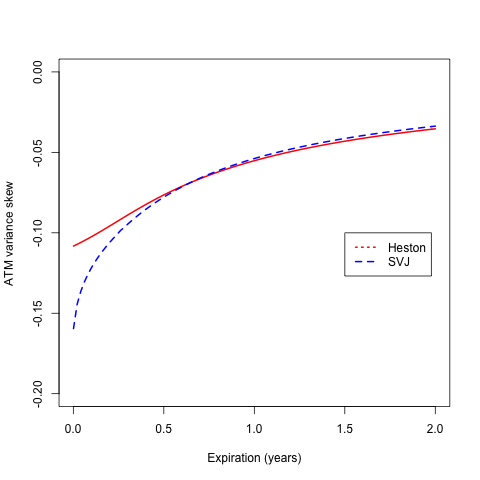

In [22]:
%%R

curve(atmVarSkewV(phiHeston(parSVJJ),x),from=.001,to=2,col="red",lty=1,lwd=2,ylab="ATM variance skew",xlab="Expiration (years)",ylim=c(-.2,0)) 
curve(atmVarSkewV(phiSVJ(parSVJJ),x),from=.001,to=2,col="blue",lty=2,lwd=2,add=T)

leg.txt <- c("Heston", "SVJ") 
legend(x=1.5,y=-.1,leg.txt,lty=c(3,2),col=c("red","blue"),lwd=c(2,2))

<a name="fig:shortDatedSkew"></a>Figure 9: The solid line is a graph of the at-the-money variance skew in the Heston model with BCC SVJJ parameters vs time to expiration. The dashed line is the SVJ variance skew with the same parameters.

###SVJ skew vs sum of Heston and MJD skews

- <span> [Figure 10](#fig:combskew) plots the at-the-money variance skew
corresponding to the Bakshi-Cao-Chen SVJ model fit together with the sum
of the Heston and jump-diffusion at-the-money variance skews with the
same parameters (see [Table 1](#table:jumpfits)).</span>


- <span> We see that (at least with this choice of parameters), not only
does the characteristic function factorize but the at-the-money variance
skew is almost additive. </span>

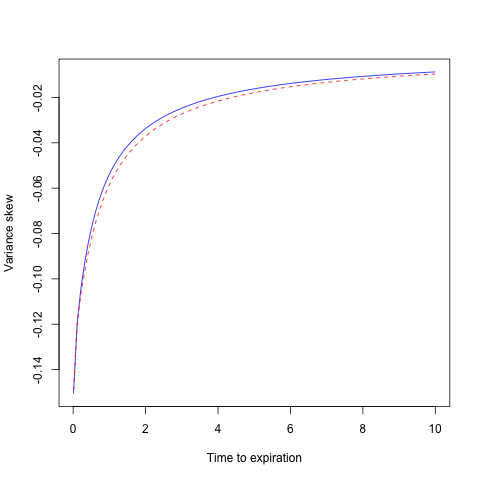

In [23]:
%%R

skewSum <- function(x){atmVarSkewV(phiHeston(parSVJJ),x)+atmVarSkewV(phiMJD(parSVJJ),x)}

curve(atmVarSkewV(phiSVJ(parSVJJ),x),from=.01,to=10,col="blue",ylab="Variance skew", xlab="Time to expiration")
curve(skewSum(x),from=.01,to=10,col="red",add=T,lty=2)

<a name="fig:combskew"></a>Figure 10: The solid line is a graph of the at-the-money variance skew in the SVJ
model with BCC parameters vs time to expiration. The dashed line
represents the sum of at-the-money Heston and jump-diffusion skews with
the same parameters.

### SVJ model assumptions are unrealistic

- <span> In the SVJ model, after the stock price has jumped, the
volatility will stay unchanged because the jump process is uncorrelated
with the volatility process.</span>

    - <span> This is inconsistent with both intuition and empirically observed
properties of the time series of asset returns.</span>

    - <span>In practice, after a large move in the underlying, implied
volatilities always increase substantially (*i.e.* they jump).</span>

### Stochastic volatility with simultaneous jumps in stock price and volatility (SVJJ)

- <span>As we noted earlier in our discussion of the SVJ model, it is
unrealistic to suppose that the instantaneous volatility wouldn’t jump
if the stock price were to jump.</span>


- <span> Conversely, adding a simultaneous upward jump in volatility to
jumps in the stock price allows us to maintain the clustering property
of stochastic volatility models: recall that “large moves follow large
moves and small moves follow small moves”.</span>



- <span>In a couple of presentations, Andrew Matytsin describes a model
that is effectively SVJ with a jump in volatility:</span>

    - <span>Jumps in the stock price are accompanied by a jump
$v \mapsto v+\gamma_v$ in the instantaneous volatility.</span>

### The SVJJ characteristic function

The SVJJ characteristic function is given by

<a name="eq:SVJJcharfn"></a>(7)

$$\phi_T(u)= \exp \left\{\hat C(u,T)\,\bar v+\hat
D(u,T)\,v \right\}
$$

with $C(u,T)$ and $D(u,T)$ given by

\begin{eqnarray*}
\hat C(u,T)&=&C(u,T)+\lambda_J\, T \,\left[e^
{iu\alpha-u^2\delta^2/2}I(u,T)-1-i\,u\,\left(e^{\alpha+\delta^2/2}-1\right)\right]\\
\hat D(u,T)&=&D(u,T)\end{eqnarray*}

where

\begin{eqnarray*}
I(u,T)&=&\frac{1}{T}\int_0^T{e^{\gamma_v D(u,t)}dt}\\
&=&-\frac{1}{T}\,\frac{2 \gamma_v}{p_+ p_-}\int_0^{-\gamma_v
D(u,T)}{\frac{e^{-z}dz}{(1+z/p_+)(1+z/p_-)}}\end{eqnarray*}

and $$p_\pm =\frac{\gamma_v}{\eta^2}(\beta-\rho \eta u i \pm d)$$

### Asymptotics of the SVJJ model

- <span> In the limit $\gamma_v\rightarrow 0$, we have
$I(u,T)\rightarrow 1$ and by inspection, we retrieve the SVJ
model.</span>


- <span> Also, in the limit $T\rightarrow 0$, $I(u,T)\rightarrow 1$ and in
that limit, the SVJJ characteristic function is identical to the SVJ
characteristic function.</span>

- The short-dated volatility skew is a function of the jump compensator only
and this compensator is identical in the SVJ and SVJJ cases. 

   - Intuitively, when the stock price jumps, the volatility jumps but this has no effect in the $T\rightarrow 0$ limit because by assumption, an at-the-money option is always out-of-the-money after the jump and its time value is zero no matter what the volatility is.


- <span>On the other hand, in the $T\rightarrow \infty$ limit, the skew
should increase because the effective volatility of volatility increases
due to (random) jumps in volatility.</span>

Let's now code the SVJJ characteristic function.

In [24]:
%%R

phiSVJJ <- function(params){
    
    lambda <- params$lambda 
    rho <- params$rho 
    eta <- params$eta 
    vbar <- params$vbar 
    v <- params$v 
    lambdaJ <- params$lambdaJ 
    alpha <- params$alpha 
    delta <- params$delta 
    gammaV <- params$gammaV 
    
    function(u, t){

    al <- -u*u/2 - 1i*u/2 
    bet <- lambda - rho*eta*1i*u 
    gam <- eta^2/2 
    d <- sqrt(bet*bet - 4*al*gam) 
    rp <- (bet + d)/(2*gam) 
    rm <- (bet - d)/(2*gam) 
    g <- rm / rp 
    D <- rm * (1 - exp(-d*t))/ (1 - g*exp(-d*t)) 
    Dfunc <- function(t){rm * (1 - exp(-d*t))/ (1 - g*exp(-d*t))} 
    C <- lambda * (rm * t - 2/eta^2 * log( (1 - g*exp(-(d*t)))/(1 - g) ) ) 
    
    pplus <- gammaV/eta^2*(bet- rho*eta*u*1i + d) 
    pminus <- gammaV/eta^2*(bet- rho*eta*u*1i - d) 
    
    integrandR <- function(t){Re(exp(gammaV*Dfunc(t)))} 
    integrandI <- function(t){Im(exp(gammaV*Dfunc(t)))} 
    
    bigI <- 1/t*(integrate(integrandR,lower=0,upper=t,rel.tol=0.0000000001,subdivisions=1000)$value+
                 1i*integrate(integrandI,lower=0,upper=t,rel.tol=0.0000000001,subdivisions=1000)$value) 
    psi <- lambdaJ*t*( (exp(1i*u*alpha-u^2*delta^2/2)*bigI -1)-1i*u*(exp(alpha+delta^2/2)-1))
    
    return(exp(C*vbar + D*v + psi)) 
    }
}

### Remarks on the fits

- <span>These estimates all relate to different dates.</span>

    - <span>We can’t expect the volatility surfaces they generate to be the
same shape.</span>

- <span> Nevertheless, the shape of the SPX volatility surface doesn’t
really change much over time so it does make some sense to compare
them.</span>

Let's now compare the ATM vol skew term structure for Heston, SVJ and SVJJ models:

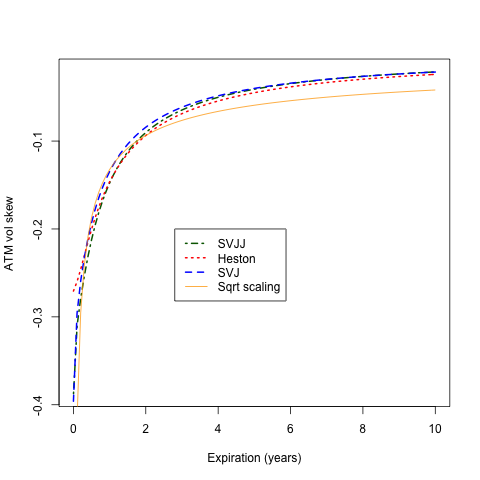

In [25]:
%%R

# To add SVJJ curve, we need to explicitly vectorize the function:
f <- function(u,t){sapply(u,function(u){phiSVJJ(parSVJJ)(u,t)})}
sk <- function(t){sapply(t,function(x){atmSkewV(f,x)})}

# Note that SVJJ comptutations are slow!!

curve(sk(x),from=0.003,to=10,col="dark green",type="l",lwd=2,lty=4,ylab="ATM vol skew",xlab="Expiration (years)") 
curve(atmSkewV(phiHeston(parSVJJ),x),from=.001,to=10,col="red",lty=3,lwd=2,add=T) 
curve(atmSkewV(phiSVJ(parSVJJ),x),from=.001,to=10,col="blue",lty=2,lwd=2,add=T)

# Compare with sqrt(t) scaling
skew2 <- atmSkew(phiHeston(parSVJJ),2) 
curve(skew2/sqrt(x/2),from=.001,to=10,col="orange",ylim=c(-.4,0),add=T)

leg.txt <- c("SVJJ","Heston", "SVJ", "Sqrt scaling") 
legend(x=2.8,y=-.2,leg.txt,lty=c(4,3,2,1),col=c("dark green","red","blue","orange"),lwd=c(2,2,2,1))

<a name="fig:combskewSVJJ"></a>Figure 11: Term structure of at-the-money volatility skew with BCC parameters for
various models

### SVJJ ATM skew for short dates

Now a zoomed version of Figure 11:

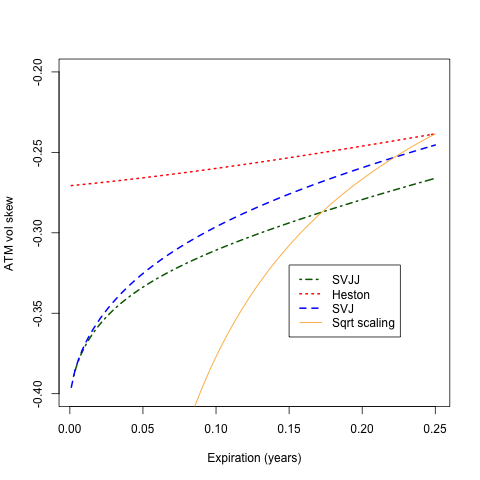

In [26]:
%%R

curve(sk(x),from=0.0025,to=.25,col="dark green",type="l",lwd=2,lty=4,ylab="ATM vol skew",xlab="Expiration (years)",ylim=c(-.4,-.2)) 
curve(atmSkewV(phiHeston(parSVJJ),x),from=.001,to=.25,col="red",lty=3,lwd=2,add=T) 
curve(atmSkewV(phiSVJ(parSVJJ),x),from=.001,to=.25,col="blue",lty=2,lwd=2,add=T) 

# Compare with sqrt(t) scaling
skew25 <- atmSkew(phiHeston(parSVJJ),.25) 
curve(skew25/sqrt(x/.25),from=.001,to=.25,col="orange",add=T)

leg.txt <- c("SVJJ","Heston", "SVJ", "Sqrt scaling") 
legend(x=.15,y=-.32,leg.txt,lty=c(4,3,2,1),col=c("dark green","red","blue","orange"),lwd=c(2,2,2,1))

<a name="fig:shortdatedskewSVJJ"></a>Figure 12: This graph is a short-expiration detailed view of the graph shown in [Figure 11](#fig:combskewSVJJ).

### Remarks on the SVJJ ATM skew


- <span>We note that the term structure of volatility skew is in
accordance with our intuition. </span>


- <span>In particular, adding a jump in volatility doesn’t help explain
extreme short-dated volatility skews.</span>


- <span> However relative to stochastic volatility and SVJ models, it does
reduce the volatility of volatility required to fit longer-dated
volatility skews even if that comes at the expense of a seemingly even
more unreasonable estimate for the average stock price jump.</span>

### The decay of skew due to jumps

* The effect of jumps on the volatility skew decays very rapidly beyond a certain time to expiration.


* To estimate this characteristic time, we note that prices of European options depend only on the final distribution of stock prices and if the jump size is of the order of only one standard deviation $\sigma \sqrt{T}$, a single jump has little impact on the shape of this distribution.


* It can be shown (see *The Volatility Surface*) that  the $T \rightarrow 0$ skew is given by the jump compensator $\mu_J$.

    - We can generate a given $\mu_J$ either with frequent small jumps or with infrequent big jumps.
    - If there are many small jumps, returns will be hard to distinguish from normal over a reasonable time interval.
    - On the other hand, if there are infrequent big jumps and time to expiration is sufficiently short, below some characteristic time $T^*$ say, we should be able to detect the presence of the jump in the final return distribution. 

###The characteristic timescale $T^\star$

* We compute $T^*$ by equating 

    $$-\left(e^{\alpha+\delta^2/2}-1\right)\approx \sigma \sqrt{T^*}$$

* [Figure 12](#fig:meltingJumps) shows the terminal return distributions for various expirations corresponding to the solid-line parameters from Table 2: 
    
    $$\sigma=0.2;\,\lambda= 0.5;\,\alpha=   -0.15;\,\delta=   0.05.$$

<blockquote><div style="background-color:#E8E8E8; color:#000000; font-style: normal;" >

The jump compensator (or expected move in the stock price due to jumps)
drives the skew in the short-expiration limit while the decay of ATM
skew is driven by the expected jump size.
</div>

</blockquote>


### JD density versus normal density

If we wait long enough, jumps become indinguishable *ex post* from moves due to diffusion.  To see this, we first build a function to compute the density from the characteristic function.

In [27]:
%%R

pPhi <- function(phi,x,t){
    
    integrand <-  function(u){Re(exp(-1i*x*u)*phi(u - 1i/2, t))}
    res <- integrate(integrand,lower=0,upper=Inf,rel.tol=0.0000000001,subdivisions=1000)$value/pi
    return(res)
}

# Vectorize the function
pPhiV <- function(phi,xVec,t){sapply(xVec,function(x){pPhi(phi,x,t)})}

In [28]:
%%R

# Compute means and standard deviations of distributions
pMean <- function(phi,t){integrate(function(x){pPhiV(phi,x,t)*x},lower=-5,upper=5)$value}
pMean(phiMJD(paramsMJD1),4/12)

m2 <- pMean(phiMJD(paramsMJD1),2/12)
m4 <- pMean(phiMJD(paramsMJD1),4/12)
m6 <- pMean(phiMJD(paramsMJD1),6/12)
m8 <- pMean(phiMJD(paramsMJD1),8/12)


pVar <- function(phi,t){integrate(function(x){pPhiV(phi,x,t)*x^2},lower=-5,upper=5)$value}

s2 <- sqrt(pVar(phiMJD(paramsMJD1),2/12)-m2^2);
s4 <- sqrt(pVar(phiMJD(paramsMJD1),4/12)-m4^2);
s6 <- sqrt(pVar(phiMJD(paramsMJD1),6/12)-m6^2);
s8 <- sqrt(pVar(phiMJD(paramsMJD1),8/12)-m8^2);



Now compare jump-diffusion and normal densities for the various expiries:

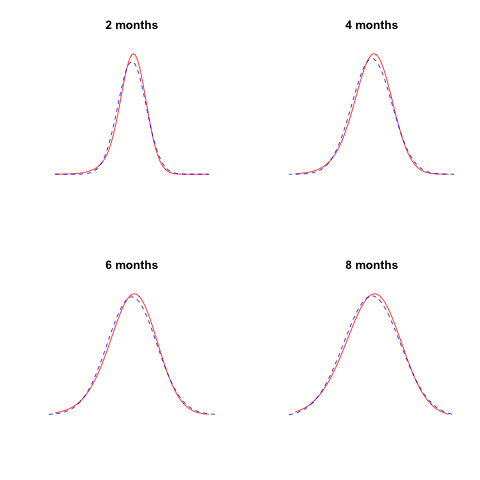

In [29]:
%%R



par(mfrow=c(2,2))
curve(pPhiV(phiMJD(paramsMJD1),x,2/12),from=-.5,to=.5,col="red",xlab=NA,ylab=NA,yaxt="n",xaxt="n",frame.plot=F,main="2 months");
curve(dnorm(x,mean=m2,sd=s2),from=-.5,to=.5,col="blue",add=T,lty=2);
curve(pPhiV(phiMJD(paramsMJD1),x,4/12),from=-.5,to=.5,col="red",xlab=NA,ylab=NA,yaxt="n",xaxt="n",frame.plot=F,main="4 months");
curve(dnorm(x,mean=m4,sd=s4),from=-.6,to=.6,col="blue",add=T,lty=2);
curve(pPhiV(phiMJD(paramsMJD1),x,6/12),from=-.5,to=.5,col="red",xlab=NA,ylab=NA,yaxt="n",xaxt="n",frame.plot=F,main="6 months");
curve(dnorm(x,mean=m6,sd=s6),from=-.7,to=.7,col="blue",add=T,lty=2);
curve(pPhiV(phiMJD(paramsMJD1),x,8/12),from=-.5,to=.5,col="red",xlab=NA,ylab=NA,yaxt="n",xaxt="n",frame.plot=F,main="8 months");
curve(dnorm(x,mean=m8,sd=s8),from=-.8,to=.8,col="blue",add=T,lty=2);
par(mfrow=c(1,1))

<a name="fig:meltingJumps"></a>Figure 13: As time to expiration increases, the return
distribution looks more and more normal.  The solid line is the
jump-diffusion pdf and for comparison, the dashed line is the normal
density with the same mean and standard deviation.  With the
parameters used to generate these plots, the characteristic time
$T^*=0.67$.

### Implications for SVJ calibration

- With reasonable parameters, jumps affect the volatility skew only for short expirations.


- Stochastic volatility drives the term structure of skew for longer expirations.


- Thus, calibration of the SVJ model is a well-posed problem in practice.

### 3D plots of SPX and fitted SVJ surfaces

First, here are some SVJ parameters that generate a more or less decent fit to the volatility surface as of September 15, 2005:

In [30]:
%%R

paramsSVJ050915 <- list(
    v= 0.0158,
    vbar=0.0439,
    eta=0.3038,
    rho=-0.6974,
    lambda=0.5394,
    lambdaJ = 0.1308,
    delta = 0.0967,
    alpha = -0.1151
    ) 

Here are the SVI parameters corresponding to the SVI fit shown in Figures 3.2 and 3.3 of The Volatility Surface:

In [31]:
%%R

texp <- c(0.003832991, 0.098562628, 0.175336527, 0.251996350, 0.501140771, 0.750171116, 1.248574036, 1.746748802)

svidata <- c(
 c(-0.0001449630, 0.0092965440, 0.0196713280, -0.2941176470,-0.0054273230),
 c(-0.000832134	, 0.024439766 , 0.069869455 , -0.299975308 , 0.02648364  ), 
 c(-0.0008676750, 0.0282906450, 0.0873835580, -0.2892204290, 0.0592703000), 
 c(-0.0000591593, 0.0331790820, 0.0812872370, -0.3014043240, 0.0652549210),
 c(0.0011431940	, 0.0462796440, 0.1040682980, -0.3530782140, 0.0942000770), 
 c(0.0022640980	, 0.0562604150, 0.1305339330, -0.4387409470, 0.1111230690), 
 c(0.0040335530	, 0.0733707550, 0.1707947600, -0.4968970370, 0.1496609160), 
 c(0.0034526910	, 0.0917230540, 0.2236814130, -0.4942213210, 0.1854128490));

sviMatrix <- as.data.frame(t(array(svidata,dim=c(5,8))));
colnames(sviMatrix)<-c("a","b","sig","rho","m")

# Inspect the matrix
sviMatrix

              a           b        sig        rho            m
1 -0.0001449630 0.009296544 0.01967133 -0.2941176 -0.005427323
2 -0.0008321340 0.024439766 0.06986945 -0.2999753  0.026483640
3 -0.0008676750 0.028290645 0.08738356 -0.2892204  0.059270300
4 -0.0000591593 0.033179082 0.08128724 -0.3014043  0.065254921
5  0.0011431940 0.046279644 0.10406830 -0.3530782  0.094200077
6  0.0022640980 0.056260415 0.13053393 -0.4387409  0.111123069
7  0.0040335530 0.073370755 0.17079476 -0.4968970  0.149660916
8  0.0034526910 0.091723054 0.22368141 -0.4942213  0.185412849


###Comparing model and empirical volatility surfaces

- One good way to see how well the
SVJ model fits the empirical implied volatility surface overall is
to compare the two volatility surfaces graphically.}

- We see from
[Figure 13](#fig:spxsvjcompare)  that in contrast to the Heston case, the SVJ model succeeds
in generating a volatility surface that has the main features of the
empirical surface although the fit is not perfect.

- Again, for longer
expirations, the fit is pretty good.



Now generate a 3D plot of the SVJ surface:

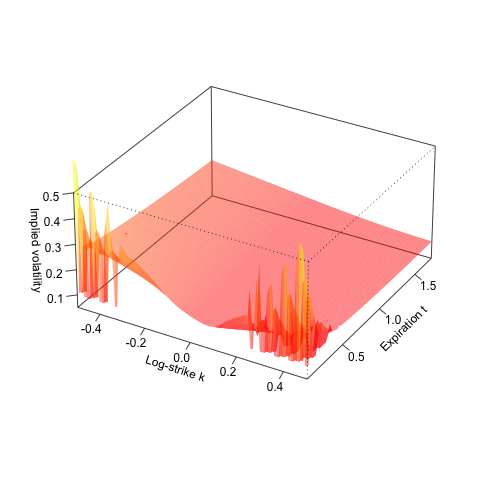

In [32]:
%%R

k <- seq(-.5,.5,0.01) # Vector of log-strikes
t <- seq(0.04,1.74,0.02) # Vector of times

vol1 <- function(k,t){bsvol(phiSVJ(parSVJJ),k,t)}
vol2 <- function(k,t){sapply(k,function(k){vol1(k,t)})}
volSVJ <- function(k,t){sapply(t,function(t){vol2(k,t)})}

zSVJ <- volSVJ(k,t) 
zSVJ <- (zSVJ>.1)*zSVJ+(zSVJ <=.15)*.15 

# First the analytical formula: 
z <- (zSVJ>.05)*zSVJ+(zSVJ <= 0.05)*.05 

# Add colors
nbcol <- 100 
color <- rainbow(nbcol,start=.0,end=.2,alpha=0.5) 

nrz <- nrow(z)
ncz <- ncol(z)
# Compute the z-value at the facet centres
zfacet <- z[-1, -1] + z[-1, -ncz] + z[-nrz, -1] + z[-nrz, -ncz]
# Recode facet z-values into color indices
facetcol <- cut(zfacet, nbcol) 

# Generate 3D plot of SVJ surface
persp(k, t, zSVJ-0.05, col=color[facetcol], phi=30, theta=30, 
    r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=20,ticktype="detailed",
    shade=.5,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied volatility",zlim=c(.05,.5)) 

Next plot the empirical surface:

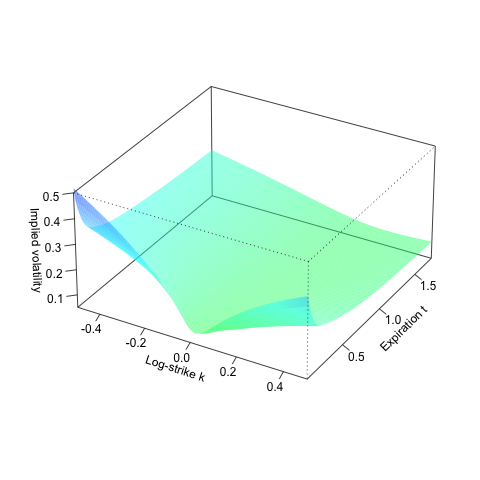

In [33]:
%%R

volTVS <- function(k,t){sqrt(sviW(sviMatrix,texp,k,t)/t)}

z2 <- t(volTVS(k,t))  # Array of empirical volatilities

# Add colors
nbcol <- 100 
color2 <- rainbow(nbcol,start=.4,end=.6,alpha=0.5) 
nrz <- nrow(z2)
ncz <- ncol(z2)
# Compute the z-value at the facet centres
zfacet <- z2[-1, -1] + z2[-1, -ncz] + z2[-nrz, -1] + z2[-nrz, -ncz]
# Recode facet z-values into color indices
facetcol <- cut(zfacet, nbcol) 

# Generate 3D plot
par(new=T) # Add to existing plot 
persp(k, t, z2, col=color2[facetcol], phi=30, theta=30, 
    r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=20,ticktype="detailed",
    shade=.5,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied volatility",zlim=c(.05,.5)) 

A function to superimpose the two surfaces and easily change perspective:

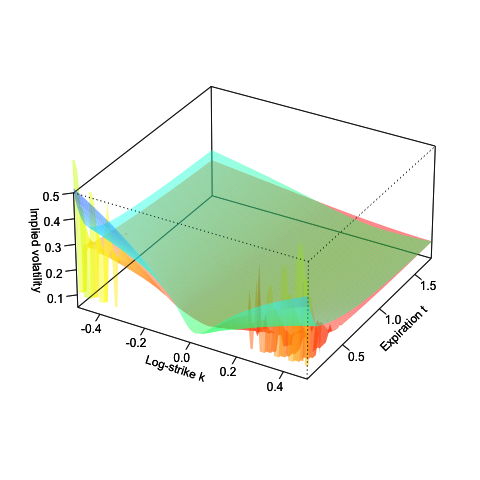

In [34]:
%%R

view <- function(phi,theta){

# Generate 3D plot of analytical solution
persp(k, t, zSVJ-0.05, col=color[facetcol], phi=phi, theta=theta, 
    r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=70,ticktype="detailed",
    shade=.5,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied volatility",zlim=c(.05,.5)) 
    
par(new=T)  # To superimpose

persp(k, t, z2, col=color2[facetcol], phi=phi, theta=theta, 
    r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=70,ticktype="detailed",
    shade=.5,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied volatility",zlim=c(.05,.5)) 
}

view(30,30)

<a name="fig:spxsvjcompare"></a>Figure 13: Comparison of the empirical SPX implied volatility surface with the
SVJ fit as of September 15, 2005. In contrast to the Heston case, the
major features of the empirical surface are replicated by the SVJ model.
The upper surface is the empirical SPX volatility surface and the
reddish lower one the SVJ fit. The SVJ fit surface has been shifted down
by 5 volatility points for ease of visual
comparison.

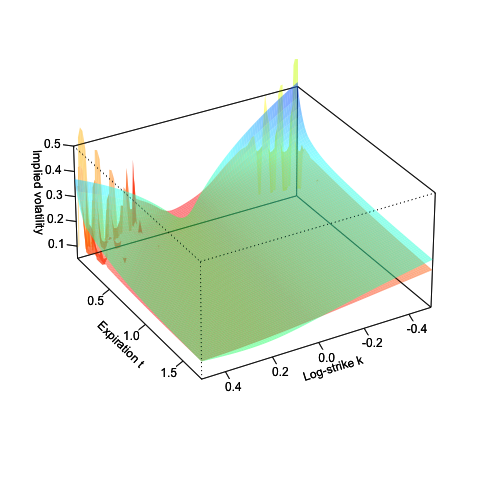

In [35]:
%R view(30,150);

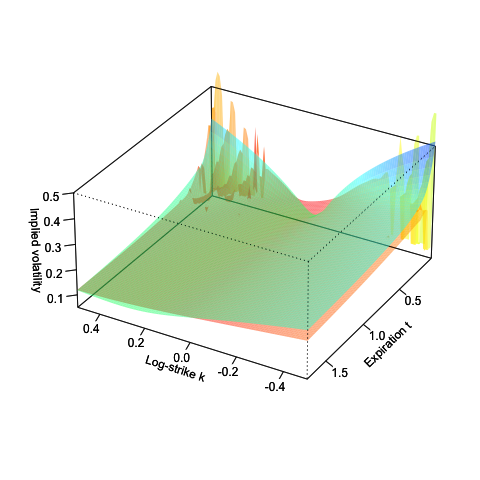

In [36]:
%R view(30,210);

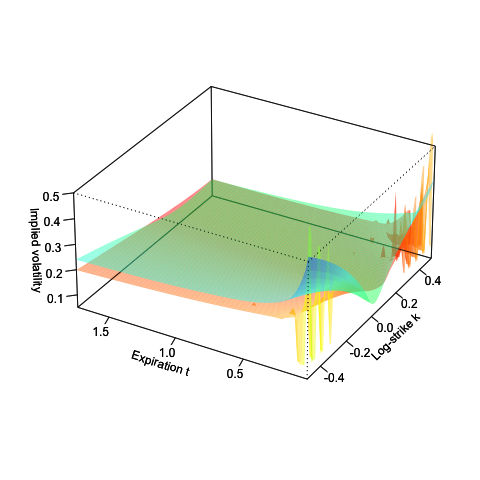

In [37]:
%R view(30,300);

### Why the SVJ model wins

- <span> SVJ fits the observed implied volatility surface reasonably well
in contrast to the Heston model.</span>


- <span>You might think that making dynamics more reasonable by including
jumps in volatility as in the SVJJ model might generate surfaces that
fit even better.</span>

    - <span> Sadly, we can see from Figures [11](#fig:combskewSVJJ) and
[12](#fig:shortdatedskewSVJJ) that not only does the SVJJ model have more
parameters than the SVJ model, but it’s harder to fit to observed option
prices.</span>


- <span> The SVJ model thus emerges as a clear winner in the comparison
between Heston, SVJ and SVJJ models.</span>

### References

<br />

<div class="reflist" style="list-style-type: decimal;">

<ol>
  
 
 
  <li id="cite_note-BCC"><span class="mw-cite-backlink"><b><a href="#cite_ref-BCC">^</a></b></span>   Bakshi, Gurdip, Charles Cao and Zhiwu Chen, Empirical performance of alternative pricing models. <span>*Journal of Finance*</span> <span>**52**(5)</span>, 2003–2049 (1997).</li>

  
   <li id="cite_note-CarrMadan"><span class="mw-cite-backlink"><b><a href="#cite_ref-CarrMadan">^</a></b></span> Peter Carr and Dilip Madan, Towards a theory of volatility trading, in <span>*Volatility: New estimation techniques for pricing derivatives*</span>, Risk Publications, Robert Jarrow, ed., 417–427 (1998).</li>

  <li id="cite_note-DPS"><span class="mw-cite-backlink"><b><a href="#cite_ref-DPS">^</a></b></span>   Duffie, Darrell, Jun Pan and Kenneth Singleton, Transform analysis and asset pricing for affine jump-diffusions, <span>*Econometrica*</span>
<span>**68**(6)</span>, 1343–1376 (2000).</li>

  <li id="cite_note-TVS"><span class="mw-cite-backlink"><b><a href="#cite_ref-TVS">^</a></b></span>Jim Gatheral, <span>*The Volatility Surface: A Practitioner’s
Guide*</span>, John Wiley and Sons, Hoboken, NJ (2006).</li>


  <li id="cite_note-Lewis"><span class="mw-cite-backlink"><b><a href="#cite_ref-Lewis">^</a></b></span>Alan Lewis, <span>*Option valuation under stochastic volatility*</span>, Finance Press, Newport Beach, CA (2000).</li>



</ol>